In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [40]:
experiments = [
    "NORT-Proxima_dynamicalpha", #Proxima - dynamic alpha with no retrain interval
    "NORT-Proxima_static-alpha", #Proxima - precalcualted alpha, no retrain interval
    "surrogate_only", ## Simple surrogate implementation
    "SS-UQ02-NORT_staticalpha", # Simple surrogate, uq:0.2, no retrain interval
    "DA_RT50", ## Proxima - dynamica alpha, testing single RT interval of 50 
    "DAallUQ_TEMP1000", ## Proxima - testing different retrain intervals and UQ's
    "SST1000_bestparameters", ## Simple surrogate - with different Retrain intervals tested
]
root_path = "/home/yzamora/proxima/examples/tests_runs"

In [41]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    
    uq_thresholds, int_list, total_time, uq_time = pa.process_times(path)
    time_df = pa.time_to_df(uq_time)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")

In [42]:
list(results["NORT-Proxima_dynamicalpha"]['temperature'])

[100, 1000, 200, 300, 400, 500, 600, 700, 800, 900]

In [70]:
_t_da = results["NORT-Proxima_dynamicalpha"]['time']
_temp_da = results["NORT-Proxima_dynamicalpha"]['temperature']
_temp_da, _t_da = zip(*sorted(zip(_temp, _t)))

_t_sa = results["NORT-Proxima_static-alpha"]['time']
_temp_sa = results["NORT-Proxima_static-alpha"]['temperature']
_temp_sa, _t_sa = zip(*sorted(zip(_temp, _t)))

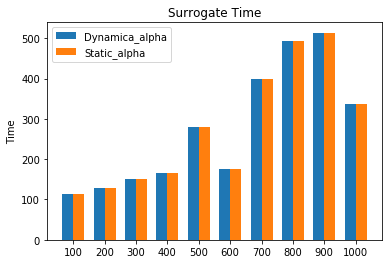

In [71]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, list(_t_da), width, label='Dynamica_alpha')
rects2 = ax.bar(x + width/2, list(_t_sa), width, label='Static_alpha')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title('Surrogate Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



plt.show()

In [94]:
def _plot_cases(cases):
    fig, ax = plt.subplots(figsize=(12,5))
    num_case = len(cases)
    total_width = 0.7
    width = total_width / num_case
    print(num_case)
    for i in range(num_case):
        case = cases[i]
        x_offset = (i - num_case / 2) * width + width / 2
        labels = list(case.get('df'))
        x = np.arange(len(labels))  # the label locations
        y = case.get('y')
        label = case.get('label')
        rects1 = ax.bar(x + x_offset, list(y), width, label=label)
        
    """for case in cases:
        labels = list(case.get('df'))
        x = np.arange(len(labels))  # the label locations
        y = case.get('y')
        label = case.get('label')
        width = 0.35  # the width of the bars 
        num_case = len(cases)
        print(num_case)
        rects1 = ax.bar(x - width/num_case, list(y), width, label=label)
        #rects2 = ax.bar(x + width/2, list(results["NORT-Proxima_static-alpha"]['time']), width, label='Static_alpha')
    """

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time')
    ax.set_title('Surrogate Time')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
        

2


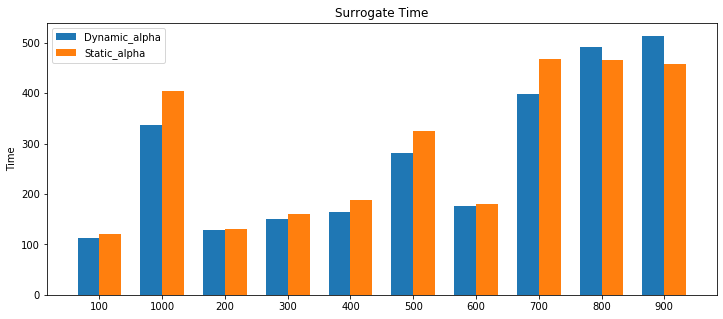

In [95]:
cases = (
        {"df": results["NORT-Proxima_dynamicalpha"]['temperature'],'y': results["NORT-Proxima_dynamicalpha"]['time'],"label":'Dynamic_alpha', "marker":"x"},
        {"df": results["NORT-Proxima_static-alpha"]['temperature'],'y': results["NORT-Proxima_static-alpha"]['time'],"label":'Static_alpha', "marker":"x"},
    )
_plot_cases(cases)